In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader
import shutil

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
randomRotation = transforms.RandomRotation(180)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.TenCrop(224),
        transforms.Lambda(lambda crops: torch.stack([normalize(transforms.ToTensor()(crop)) for crop in crops])),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../NEW_DATASET'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], batch_size=32 if x == 'train' else 32, shuffle=True if x == 'train' else False, num_workers=0)
    for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    print(inp.size())
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [4]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

/home/devtea/anaconda3/envs/pytorch-1/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [5]:
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 7)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [6]:
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [49]:
def show_images(images, cols = 2, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    print(images[0].shape)
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        print(image[0].shape)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [52]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    print('ran')

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        pred = []
        y_vals = []

        train_acc = []
        val_acc = []
        train_loss = []
        val_loss = []

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # import pdb
                # pdb.set_trace()
                
                img_list = []
                
                if phase == 'train':
                    for i in range(10):

                        inp = inputs.clone()[:, i]
                        print(inp.size())
                        img = inp[0].numpy().transpose((1,2,0))
                        
                        mean = np.array([0.485, 0.456, 0.406])
                        std = np.array([0.229, 0.224, 0.225])
                        img = std * img + mean
                        img = np.clip(img, 0, 1)
                        
                        img_list.append(img)

#                         inp = inp.to(device)
#                         labels = labels.to(device)

#                         # zero the parameter gradients
#                         optimizer.zero_grad()

#                         # forward
#                         # track history if only in train
#                         with torch.set_grad_enabled(phase == 'train'):
#                             outputs = model(inp)
#                             _, preds = torch.max(outputs, 1)

#                             # import pdb
#                             # pdb.set_trace()

#                             loss = criterion(outputs, labels)

#                             # backward + optimize only if in training phase
#                             if phase == 'train':
#                                 loss.backward()
#                                 optimizer.step()

#                         # statistics
#                         running_loss += loss.item() * inp.size(0)
#                         running_corrects += torch.sum(preds == labels.data)
                    show_images(img_list)
                    break

                    epoch_loss = running_loss / dataset_sizes[phase] / 10
                    epoch_acc = running_corrects.double() / dataset_sizes[phase] / 10
            break

ran
Epoch 0/0
----------
torch.Size([7, 3, 224, 224])
torch.Size([7, 3, 224, 224])
torch.Size([7, 3, 224, 224])
torch.Size([7, 3, 224, 224])
torch.Size([7, 3, 224, 224])
torch.Size([7, 3, 224, 224])
torch.Size([7, 3, 224, 224])
torch.Size([7, 3, 224, 224])
torch.Size([7, 3, 224, 224])
torch.Size([7, 3, 224, 224])
(224, 224, 3)
(224, 3)
(224, 3)
(224, 3)
(224, 3)
(224, 3)
(224, 3)
(224, 3)
(224, 3)
(224, 3)
(224, 3)


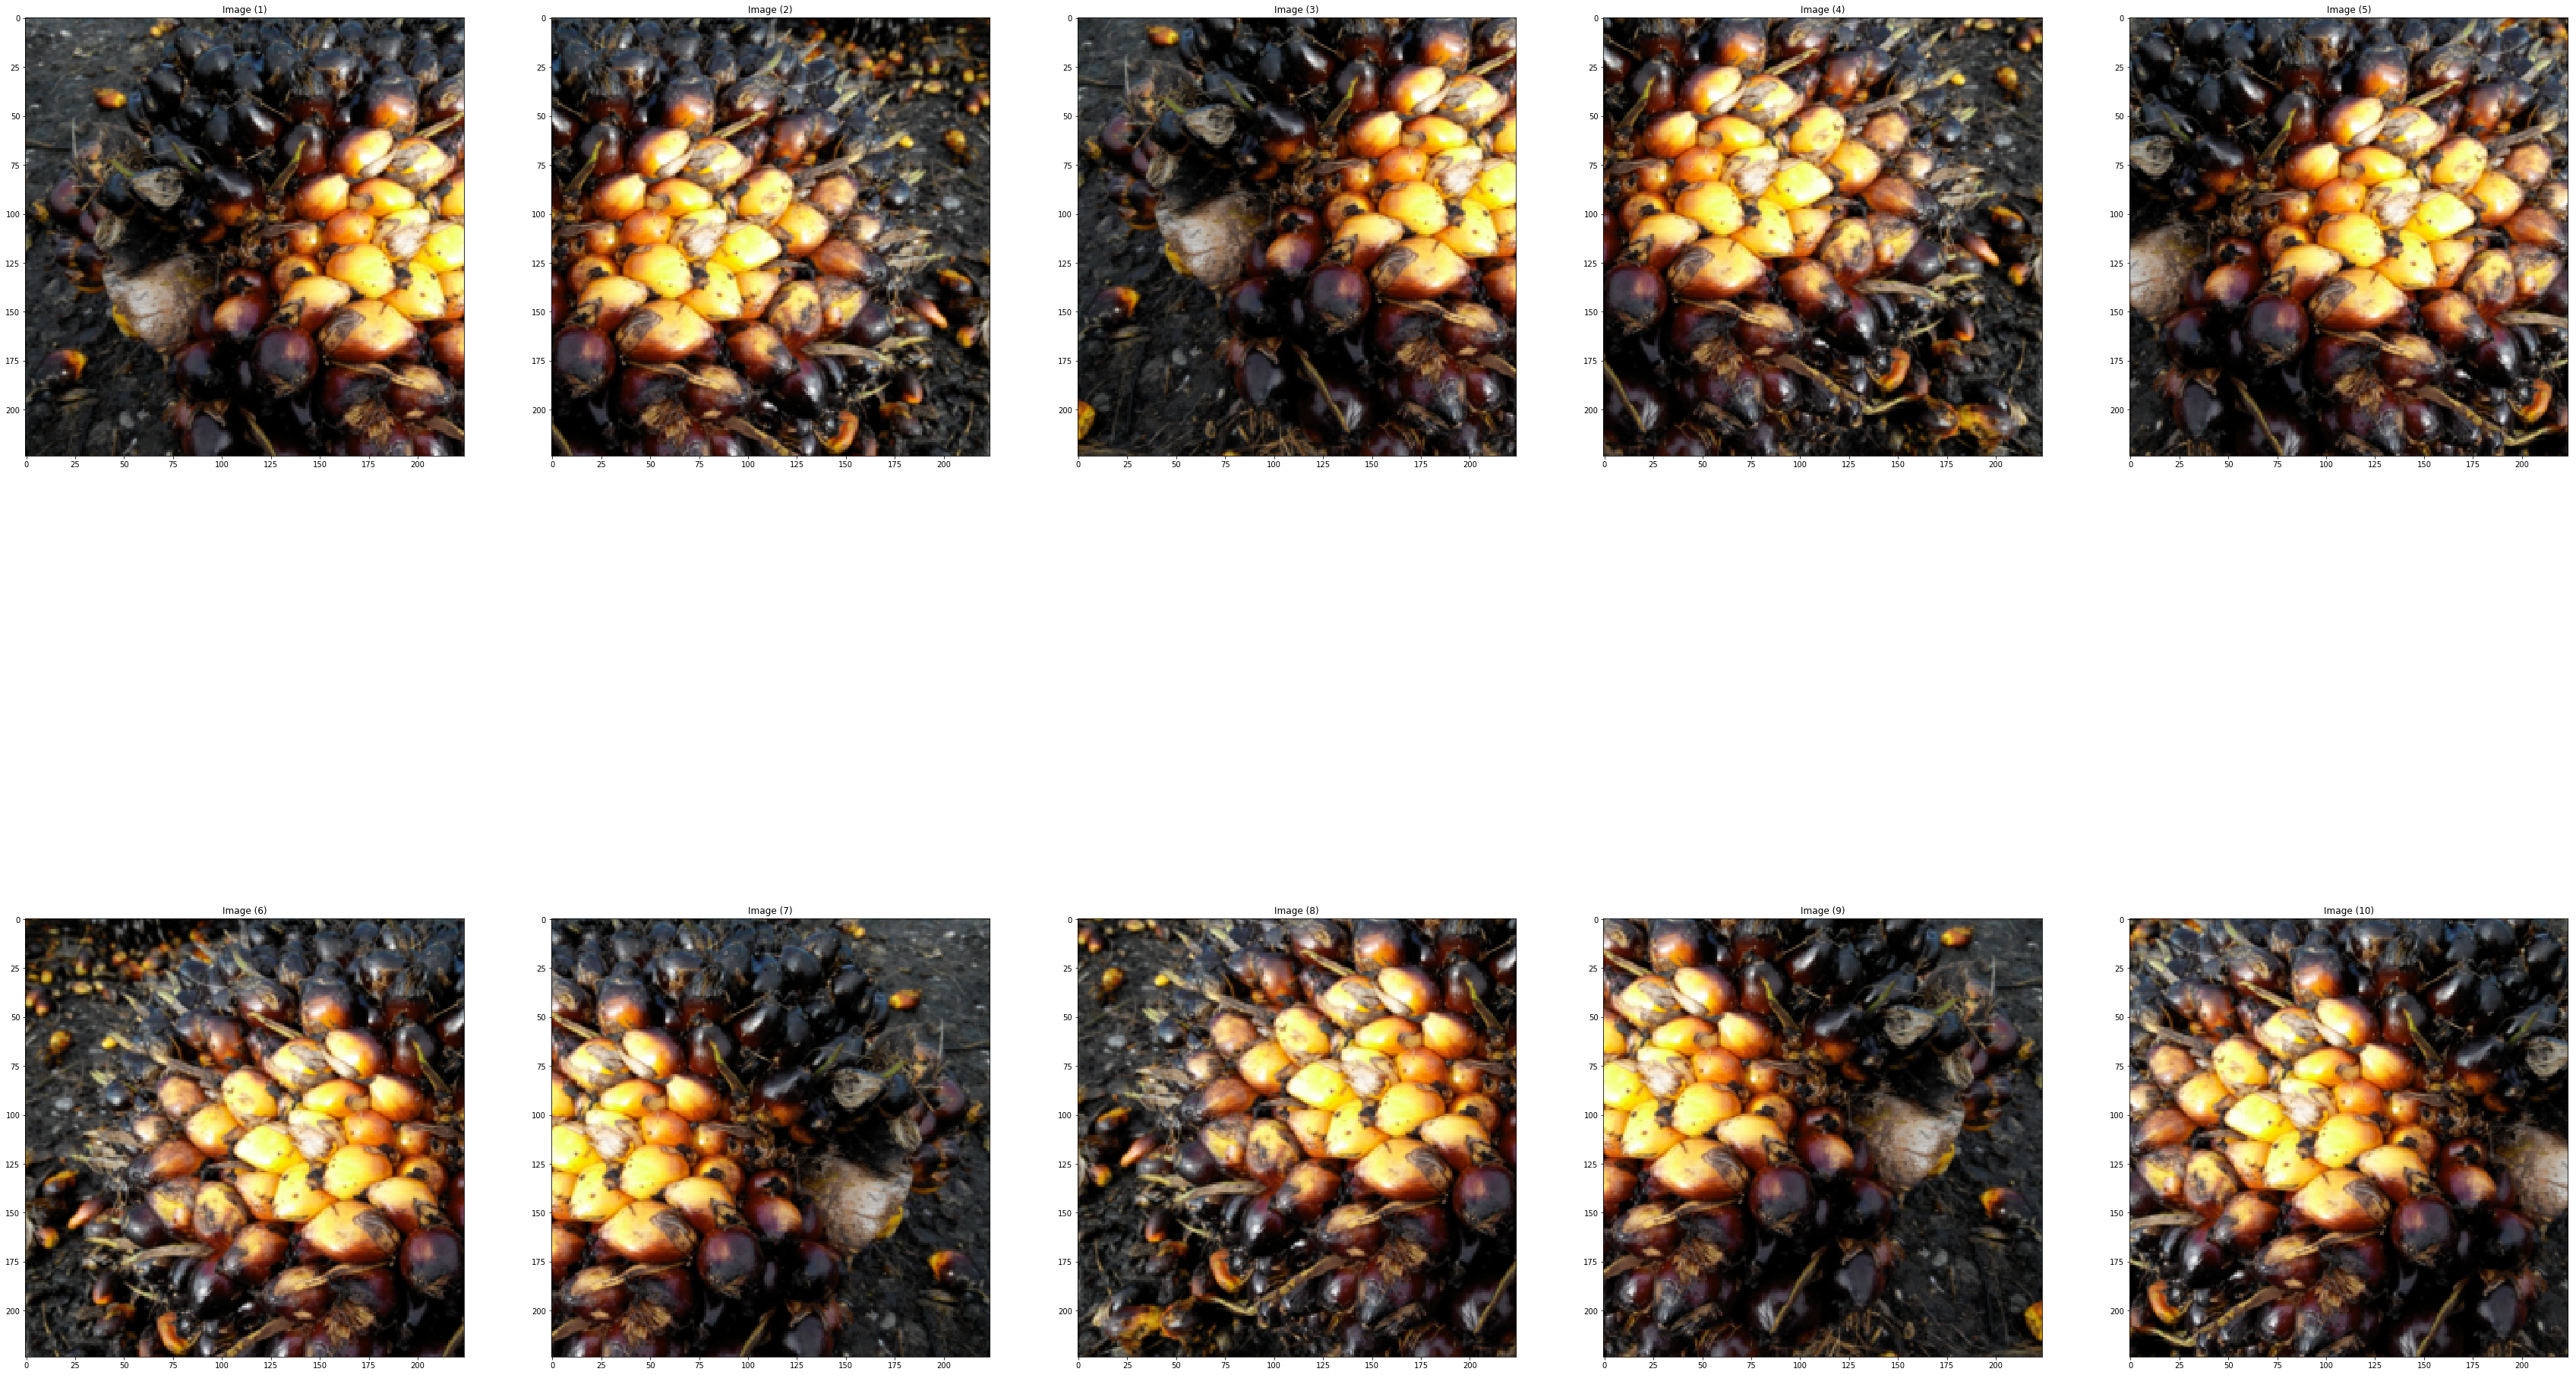

In [53]:
# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=1)

train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=1)